In [1]:
import time
from src.method_selector import MlMethodSelector, ClassicMethodSelector
from src.measurement_provider import MeasurementProvider
from src.serializer import SenMLCBORSerializer, SenMLJSONSerializer
from src.signal_generator import SignalGenerator
from sys import getsizeof
from src.metric import FeatureMetricEnum, SimilarityMetricEnum
from src.data_type import Measurement
import pandas as pd
import matplotlib as plt
from src.metric import SimilarityMetricEnum
import random
plt.rcParams["figure.dpi"] = 150
pd.set_option('display.max_columns', None)

In [12]:
def compute_sizes(dataset, compressed_data, metrics):
  senML_cbor_size_original = getsizeof(SenMLCBORSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_cbor_size_compressed = getsizeof(SenMLCBORSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_cbor_size_diff = senML_cbor_size_original - senML_cbor_size_compressed
  senML_cbor_size_ratio = senML_cbor_size_diff / senML_cbor_size_original

  senML_json_size_original = getsizeof(SenMLJSONSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_json_size_compressed = getsizeof(SenMLJSONSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_json_size_diff = senML_json_size_original - senML_json_size_compressed
  senML_json_size_ratio = senML_json_size_diff / senML_json_size_original
  return {
    'senML_cbor_size_original': senML_cbor_size_original,
    'senML_cbor_size_compressed': senML_cbor_size_compressed,
    'senML_cbor_size_diff': senML_cbor_size_diff,
    'senML_cbor_size_ratio': senML_cbor_size_ratio,

    'senML_json_size_original': senML_json_size_original,
    'senML_json_size_compressed': senML_json_size_compressed,
    'senML_json_size_diff': senML_json_size_diff,
    'senML_json_size_ratio': senML_json_size_ratio,
  }

def current_milis():
  return time.time() * 1000
  
def run_measurements(dataset, get_measurements):
  ml_method_selector = MlMethodSelector()
  # ml_method_selector.use_default_strategy([
  #   SimilarityMetricEnum.arithmetic_average,
  #   SimilarityMetricEnum.median,
  #   SimilarityMetricEnum.covariance,
  # ])
  ml_method_selector.set_measurements(dataset)
  score = ml_method_selector.train()
  print(score)

  classic_method_selector = ClassicMethodSelector()

  print("datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio")

  results = {
    "datasize": [],
    "ml_time": [],
    "classic_time": [],
    "ml_compressed_size": [],
    "classic_compressed_size": [],
    "ml_compression_ratio": [],
    "classic_compression_ratio": [],
    "ml_method": [],
    "classic_method": [],
    "ml_score": [],
    "classic_score": [],
    "ml_cbor_original_size": [],
    "ml_cbor_compressed_size": [],
    "ml_cbor_compressratio": [],
    "classic_cbor_original_size": [],
    "classic_cbor_compressed_size": [],
    "classic_cbor_compressratio": [],
    "ml_json_original_size": [],
    "ml_json_compressed_size": [],
    "ml_json_compressratio": [],
    "classic_json_original_size": [],
    "classic_json_compressed_size": [],
    "classic_json_compressratio": [],
  }

  for datasize in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # measurements = measurement_provider.to_measurements(SignalGenerator(0, datasize).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2))
    measurements = get_measurements(datasize)

    time_start = current_milis()
    compressed_data, stats, metrics = ml_method_selector.compress_with_best(measurements)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)
    metrics_score = ClassicMethodSelector().compute_similarity_with_default_strategy(measurements, compressed_data)

    ml_time = time_end - time_start
    ml_compressed_size = stats['compressed_size']
    ml_compression_ratio = stats['compression_rate'] * 100
    ml_method = stats['method_name']
    ml_score = metrics_score
    ml_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    ml_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    ml_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    ml_json_original_size = serialized_data_stats['senML_json_size_original']
    ml_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    ml_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['datasize'].append(datasize);
    results['ml_time'].append(ml_time);
    results['ml_compressed_size'].append(ml_compressed_size);
    results['ml_compression_ratio'].append(ml_compression_ratio);
    results['ml_method'].append(ml_method);
    results['ml_score'].append(ml_score);
    results['ml_cbor_original_size'].append(ml_cbor_original_size);
    results['ml_cbor_compressed_size'].append(ml_cbor_compressed_size);
    results['ml_cbor_compressratio'].append(ml_cbor_compressratio);
    results['ml_json_original_size'].append(ml_json_original_size);
    results['ml_json_compressed_size'].append(ml_json_compressed_size);
    results['ml_json_compressratio'].append(ml_json_compressratio);

    ##############################################

    time_start = current_milis()
    compressed_data, stats, metrics, metrics_score = classic_method_selector.compress_with_best_default_strategy(measurements)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)

    classic_time = time_end - time_start
    classic_compressed_size = stats['compressed_size']
    classic_compression_ratio = stats['compression_rate'] * 100
    classic_method = stats['method_name']
    classic_score = metrics_score
    classic_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    classic_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    classic_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    classic_json_original_size = serialized_data_stats['senML_json_size_original']
    classic_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    classic_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['classic_time'].append(classic_time);
    results['classic_compressed_size'].append(classic_compressed_size);
    results['classic_compression_ratio'].append(classic_compression_ratio);
    results['classic_method'].append(classic_method);
    results['classic_score'].append(classic_score);
    results['classic_cbor_original_size'].append(classic_cbor_original_size);
    results['classic_cbor_compressed_size'].append(classic_cbor_compressed_size);
    results['classic_cbor_compressratio'].append(classic_cbor_compressratio);
    results['classic_json_original_size'].append(classic_json_original_size);
    results['classic_json_compressed_size'].append(classic_json_compressed_size);
    results['classic_json_compressratio'].append(classic_json_compressratio);

    print(f'{datasize},{ml_time},{classic_time},{ml_compressed_size},{classic_compressed_size},{ml_compression_ratio},{classic_compression_ratio},{ml_method},{classic_method},{ml_score},{classic_score},{ml_cbor_original_size},{ml_cbor_compressed_size},{ml_cbor_compressratio},{classic_cbor_original_size},{classic_cbor_compressed_size},{classic_cbor_compressratio},{ml_json_original_size},{ml_json_compressed_size},{ml_json_compressratio},{classic_json_original_size},{classic_json_compressed_size},{classic_json_compressratio}')
  return pd.DataFrame.from_dict(results)

In [13]:
dataset = MeasurementProvider().get_random3()
df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).linear(2.5).sin(0.3, 0.2)))

(0.3333333333333333, 0.6)
datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
100,0.874755859375,100.719970703125,21,21,0.79,0.79,CompressNTHS_0.2,CompressNTHS_0.2,79.3945,79.3945,2291,713,0.6887821911828895,2291,713,0.6887821911828895,5354,1371,0.7439297721329847,5354,1371,0.7439297721329847
200,1.455078125,269.90234375,21,40,0.895,0.8,CompressNTHS_0.1,CompressPIP_PD_0.2,79.173,79.5699,4291,713,0.8338382661384293,4291,1093,0.7452808203216034,10495,1382,0.8683182467841829,10495,2348,0.7762744163887566
300,2.1025390625,517.421630859375,31,60,0.8966666666666666,0.8,CompressNTHS

In [7]:
# df = pd.read_csv('./results1a.csv')
# df['ml_compression_ratio'] *= 100
# df['classic_compression_ratio'] *= 100

In [8]:
df

,datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
0,100,0.874756,100.719971,21,21,79.000000,79.000000,CompressNTHS_0.2,CompressNTHS_0.2,79.3945,79.3945,2291,713,0.688782,2291,713,0.688782,5354,1371,0.743930,5354,1371,0.743930
1,200,1.455078,269.902344,21,40,89.500000,80.000000,CompressNTHS_0.1,CompressPIP_PD_0.2,79.1730,79.5699,4291,713,0.833838,4291,1093,0.745281,10495,1382,0.868318,10495,2348,0.776274
2,300,2.102539,517.421631,31,60,89.666667,80.000000,CompressNTHS_0.1,CompressPIP_ED_0.2,79.1644,79.5669,6292,913,0.854895,6292,1493,0.762715,15598,1908,0.877677,15580,3369,0.783761
3,400,2.876221,840.292969,41,81,89.750000,79.750000,CompressNTHS_0.1,CompressNTHS_0.2,79.4042,79.6056,8292,1113,0.865774,8292,1913,0.769296,20675,2406,0.883628,20675,4442,0.785151
4,500,3.561279,1192.058594,51,101,89.800000,79.800000,CompressNTHS_0.1,CompressNTHS_0.2,79.3206,79.5922,10292,1313,0.872425,10292,2313,0.775262,25847,2918,0.887105,25848,5474,0.788223
5,600,3.864014,1646.049072,61,121,89.833333,79.833333,CompressNTHS_0.1,CompressNTHS_0.2,79.2964,79.5870,12292,1513,0.876912,12292,2713,0.779287,31039,3447,0.888946,31040,6522,0.789884
6,700,4.407959,2199.137695,71,141,89.857143,79.857143,CompressNTHS_0.1,CompressNTHS_0.2,79.4720,79.6338,14380,1723,0.880181,14380,3131,0.782267,36215,3964,0.890543,36211,7551,0.791472
7,800,5.109863,2678.861816,81,161,89.875000,79.875000,CompressNTHS_0.1,CompressNTHS_0.2,79.3064,79.5944,16580,1943,0.882811,16580,3571,0.784620,41389,4482,0.891710,41376,8578,0.792682
8,900,5.864502,3419.781250,91,181,89.888889,79.888889,CompressNTHS_0.1,CompressNTHS_0.2,79.3844,79.6358,18780,2163,0.884824,18780,4011,0.786422,46549,4998,0.892629,46548,9622,0.793289
9,1000,52.541016,4161.890137,101,201,89.900000,79.900000,CompressNTHS_0.1,CompressNTHS_0.2,79.4730,79.6609,20980,2383,0.886416,20980,4451,0.787846,51675,5499,0.893585,51687,10647,0.794010


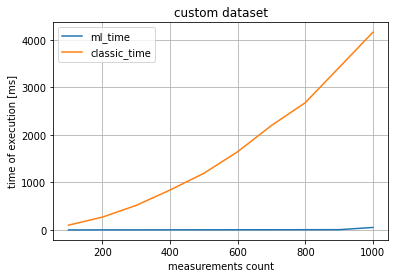

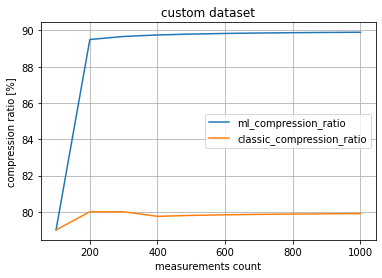

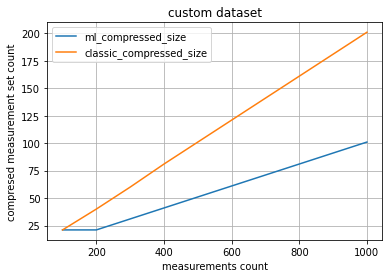

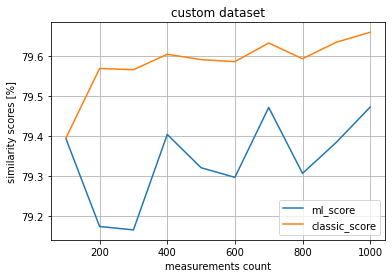

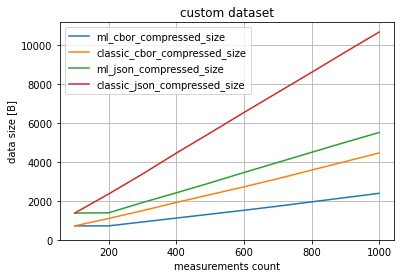

In [9]:
path = '../plot/strategy1'
ax = df.plot(x='datasize', y=['ml_time', 'classic_time'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1a.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'classic_compression_ratio'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2a.png')

ax = df.plot(x='datasize', y=['ml_compressed_size', 'classic_compressed_size'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compresed measurement set count")
ax.figure.savefig(f'{path}/3a.png')

ax = df.plot(x='datasize', y=['ml_score', 'classic_score'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4a.png')

ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'classic_cbor_compressed_size', 'ml_json_compressed_size', 'classic_json_compressed_size'], grid=True, ylim=0)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("data size [B]")
ax.figure.savefig(f'{path}/5a.png')


In [16]:
measurements1 = MeasurementProvider().json_to_measurements('stock1.json')
size1 = len(measurements1)
dataset = []
for i in range(10):
  start = int(random.randint(0, size1) * 0.7)
  end = random.randint(start, size1)
  dataset.append(measurements1[start:end])
df = run_measurements(dataset, lambda datasize: MeasurementProvider().json_to_measurements('stock1.json')[:datasize])

(1.0, 1.0)
datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
100,1.453125,102.5439453125,20,71,0.8,0.29,CompressPIP_ED_0.2,CompressNTHS_0.7,74.0635,75.9001,2521,761,0.6981356604522015,2521,1883,0.25307417691392303,5739,1446,0.7480397281756404,5739,4189,0.27008189580066216
200,2.4990234375,268.13232421875,40,20,0.8,0.9,CompressPIP_PD_0.2,CompressPIP_PD_0.1,78.7789,78.9499,4721,1201,0.7456047447574666,4721,761,0.83880533785215,11150,2507,0.7751569506726458,11148,1434,0.871367061356297
300,3.83203125,481.26416015625,60,60,0.8,0.8,CompressPIP_PD_0.2,CompressPIP_PD_0.2,79.0094,7

In [10]:
df = pd.read_csv('./results1b.csv')
df['ml_compression_ratio'] *= 100
df['classic_compression_ratio'] *= 100

In [11]:
df

,datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
0,100,1.453125,102.543945,20,71,80.000000,29.0,CompressPIP_ED_0.2,CompressNTHS_0.7,74.0635,75.9001,2521,761,0.698136,2521,1883,0.253074,5739,1446,0.748040,5739,4189,0.270082
1,200,2.499023,268.132324,40,20,80.000000,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,78.7789,78.9499,4721,1201,0.745605,4721,761,0.838805,11150,2507,0.775157,11148,1434,0.871367
2,300,3.832031,481.264160,60,60,80.000000,80.0,CompressPIP_PD_0.2,CompressPIP_PD_0.2,79.0094,79.0094,6922,1641,0.762930,6922,1641,0.762930,16544,3569,0.784272,16544,3569,0.784272
3,400,5.412842,810.362793,80,80,80.000000,80.0,CompressPIP_PD_0.2,CompressPIP_PD_0.2,79.3255,79.3255,9122,2081,0.771870,9122,2081,0.771870,21965,4649,0.788345,21965,4649,0.788345
4,500,3.497314,1046.025146,101,50,79.800000,90.0,CompressNTHS_0.2,CompressPIP_PD_0.1,75.5185,79.6397,11322,2543,0.775393,11322,1421,0.874492,27433,5831,0.787446,27398,3037,0.889152
5,600,4.113281,1449.893066,121,60,79.833333,90.0,CompressNTHS_0.2,CompressPIP_PD_0.1,71.1863,80.0252,13522,2983,0.779397,13522,1641,0.878642,32958,6979,0.788246,32900,3615,0.890122
6,700,14.948730,1931.196045,70,70,90.000000,90.0,CompressPIP_ED_0.1,CompressPIP_PD_0.1,77.5846,79.7498,15722,1861,0.881631,15722,1861,0.881631,38354,4181,0.890989,38323,4157,0.891527
7,800,16.302979,2270.412109,80,80,90.000000,90.0,CompressPIP_ED_0.1,CompressPIP_PD_0.1,74.8230,79.9976,17922,2081,0.883886,17922,2081,0.883886,43705,4670,0.893147,43700,4669,0.893158
8,900,17.564209,2919.206299,90,90,90.000000,90.0,CompressPIP_ED_0.1,CompressPIP_PD_0.1,77.7023,80.1489,20122,2301,0.885648,20122,2301,0.885648,49269,5257,0.893300,49224,5218,0.893995
9,1000,20.249023,3494.529053,100,100,90.000000,90.0,CompressPIP_ED_0.1,CompressPIP_PD_0.1,76.9016,79.7037,22322,2521,0.887062,22322,2521,0.887062,54819,5818,0.893869,54770,5771,0.894632


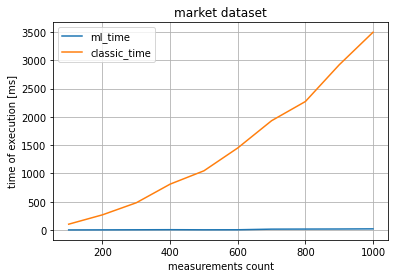

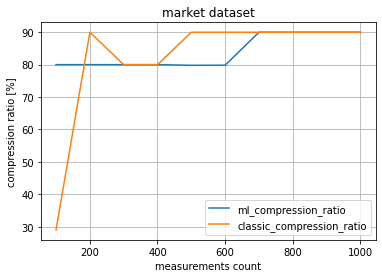

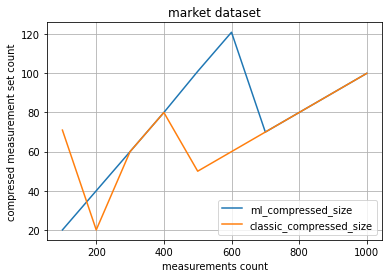

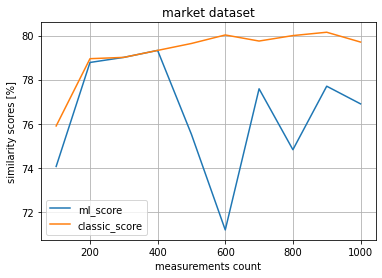

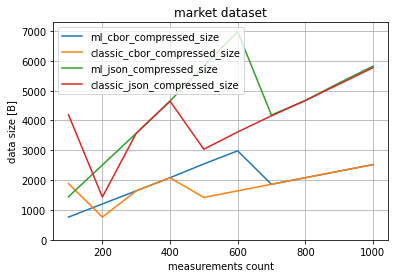

In [12]:
path = '../plot/strategy1'
ax = df.plot(x='datasize', y=['ml_time', 'classic_time'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1b.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'classic_compression_ratio'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2b.png')

ax = df.plot(x='datasize', y=['ml_compressed_size', 'classic_compressed_size'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compresed measurement set count")
ax.figure.savefig(f'{path}/3b.png')

ax = df.plot(x='datasize', y=['ml_score', 'classic_score'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4b.png')

ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'classic_cbor_compressed_size', 'ml_json_compressed_size', 'classic_json_compressed_size'], grid=True, ylim=0)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("data size [B]")
ax.figure.savefig(f'{path}/5b.png')
